In [225]:
import sys
sys.path.append('SunRay/')

import torch
print(torch.__version__)
print(torch.cuda.is_available())
import matplotlib.pyplot as plt
import sunRay.SunRayRunAnisScatLOS as anisRayLOS
import numpy as np
#plotly 3d check

1.10.0+cu102
True


In [226]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [227]:
np.linspace(30, 50,11).tolist()

[30.0, 32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 46.0, 48.0, 50.0]

In [252]:
#2.10428659  2.0
#1.75  1.1

#[eps0.102]_[alpha0.15743]
#[eps0.354]_[alpha0.15743]
#[eps0.102]_[alpha0.802]
#[eps0.354]_[alpha0.802]

# 1.424 R_sun    2.0
# 1.3845 R_sun    2.0   173MHz


import sunRay.SunRayRunAnisScatLOS as anisRayLOS
from sunRay import densityModel as dm

photon_N = 500000
idx=1
fMHz_batch=np.linspace(30, 50,11).tolist()
for parset_cur in [(0.3,0.5,True)]:
    eps_cur,alpha_cur,Scat_flag = parset_cur
    (steps_N, collect_N,  photon_N, start_r,  start_theta, 
            start_phi, epsilon ,  anis, asym,  omega0, freq0, 
            t_collect, tau, r_vec_collect_local,  k_vec_collect_local,  
            tau_collect_local,dk_refr_collect, dk_scat_collect
            ) = anisRayLOS.runRays(steps_N  = -1 , collect_N = 300, t_param = 60.0, 
            photon_N = photon_N,fMHz_batch=fMHz_batch,freq_batching=True,
            R0 = 600, Theta0 = 4/180.0*np.pi, start_phi  = 0/180.0*np.pi,
            epsilon = eps_cur, anis = alpha_cur, ne_r = dm.parkerfit,
            asym = 1.0, Te = 86.0, Scat_include = Scat_flag, Show_param = True,
            Show_result_k = False, Show_result_r = False,  verb_out = True,
            num_thread =5 , early_cut= True ,
            ignore_down=True,Absorb_include=True,dev_u =torch.device('cuda:'+str(idx)),
            save_npz = False, data_dir='../tmpRUNvec/harmo/',save_level=1)
    
    idx=idx+1
    # run in serial 

----------------------------------
Frequency : 0.0MHz
Compute with : cuda:1
----------------------------------
Refraction dt : 0.1555148191837955
Scattering dt : 1236251337259931.8
Absorb Col    : 8759565.0
Absorb  t     : 42784692.0


 37%|███▋      | 6412/17120 [02:00<03:20, 53.28it/s]

Traced final t : 1395.794 s


In [253]:
dk_refr_collect.shape

torch.Size([113, 500000])

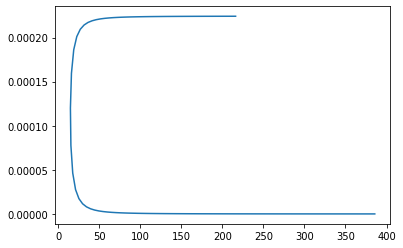

In [254]:

plt.plot(np.sqrt(np.sum(r_vec_collect_local[:,:,2]**2,axis=1)) ,dk_refr_collect[:,1].numpy())

(-413.42804489135744,
 246.20146713256835,
 -2.0923673629760744,
 43.93971462249756)

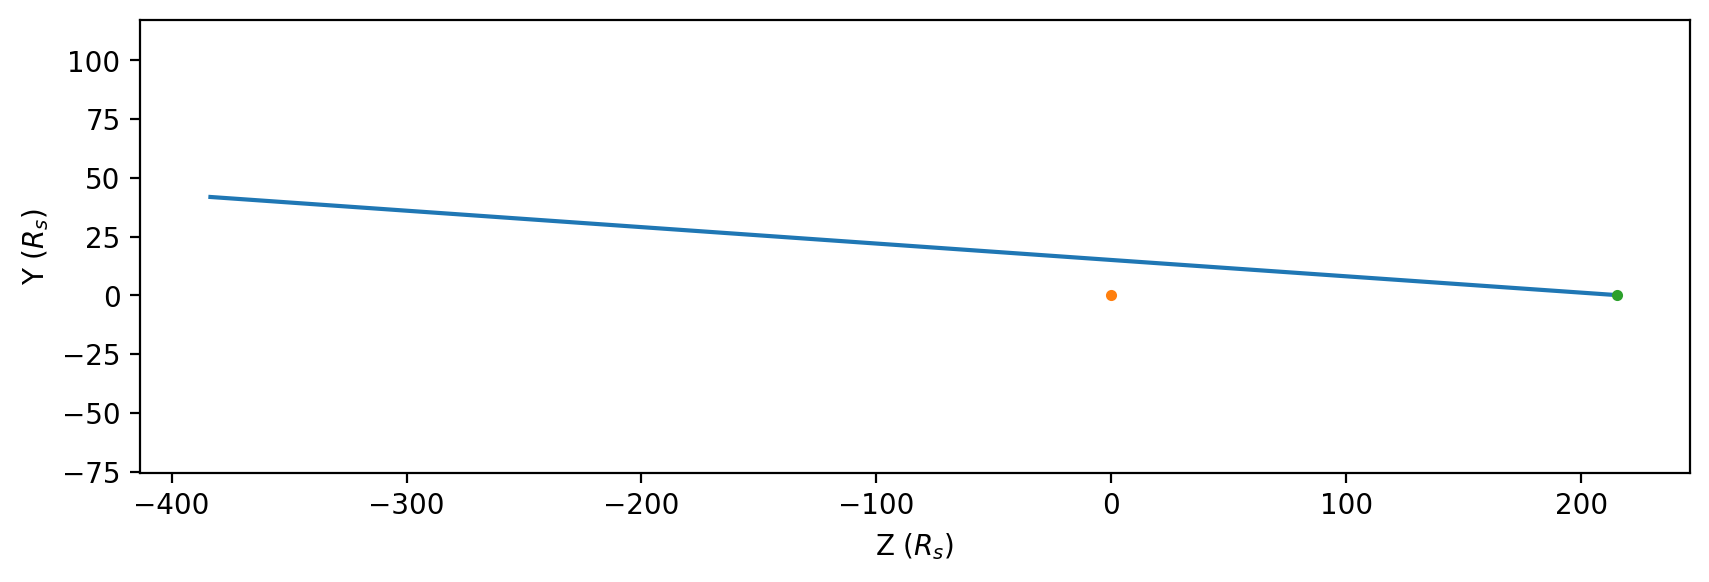

In [255]:

fig = plt.figure(figsize=[10,3],dpi=200)
plt.plot(r_vec_collect_local[0:,2,10],r_vec_collect_local[0:,0,10])
ax = plt.gca()

plt.plot(0,0,'.')
plt.plot(215,0,'.')
plt.setp(ax,xlabel='Z ($R_s$)',ylabel='Y ($R_s$)')
ax.axis('equal')

In [256]:
k_vec_collect_local[0,0,:].shape

(500000,)

(0.0, 10920.800000000001)

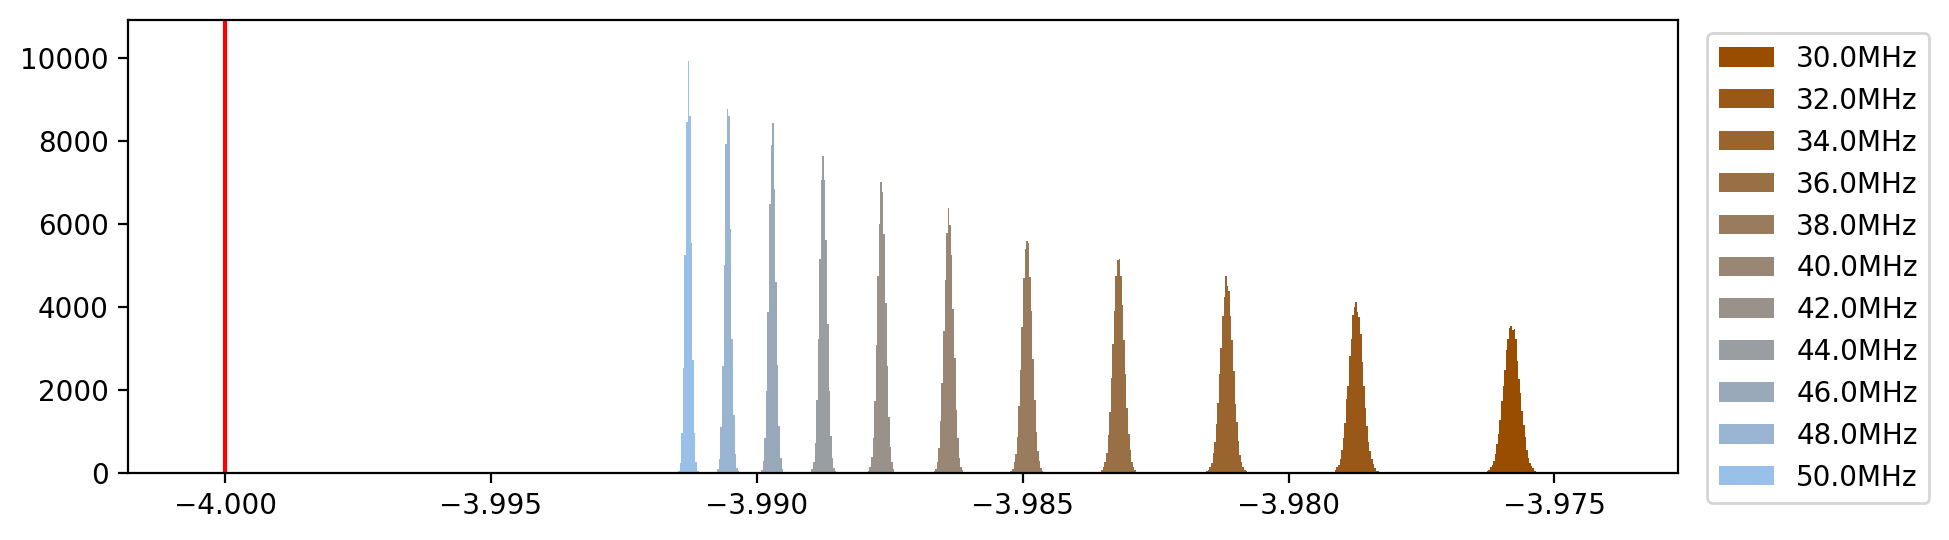

In [258]:
#b=plt.hist(np.arctan2(k_vec_collect_local[0,0,:],k_vec_collect_local[0,2,:])*180/np.pi)
theta_all = np.arctan2(k_vec_collect_local[-1,0,:],k_vec_collect_local[-1,2,:])*180/np.pi

partition_group = []
freq_group = []
theta_group = []
hist_set = []
a,bins=np.histogram(theta_all,bins=np.linspace(-4.0005,-3.974,900))


fig = plt.figure(figsize=[10,3],dpi=200)
ax = fig.add_subplot(1,1,1)

for idx,partition in enumerate(np.array_split(np.arange(photon_N), len(fMHz_batch))):
    partition_group.append(partition)
    freq_group.append(np.ones_like(partition)*fMHz_batch[idx])
    theta_group.append(theta_all[partition])

    tmp_hist = ax.hist(theta_all[partition],bins=bins,
        color=[0.6,0.3+idx/len(fMHz_batch)/2,idx/len(fMHz_batch)],label=str(fMHz_batch[idx])+'MHz')
    hist_set.append(np.max(tmp_hist[0]))

ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
ax.plot([-4,-4],[0,np.max(np.array(hist_set))*2],'r-')
ax.set_ylim([0,np.max(np.array(hist_set))*1.1])

In [259]:
mean_theta = []
std_theta = []

for idx,partition in enumerate(np.array_split(np.arange(photon_N), len(fMHz_batch))):
    partition_group.append(partition)
    freq_group.append(np.ones_like(partition)*fMHz_batch[idx])
    theta_group.append(theta_all[partition])

    mean_theta.append(np.mean(theta_all[partition]))
    std_theta.append(np.std(theta_all[partition]))

Text(0.95, 0.95, '$d\\Delta\\theta/d(\\lambda^2) = 4.22e-06$')

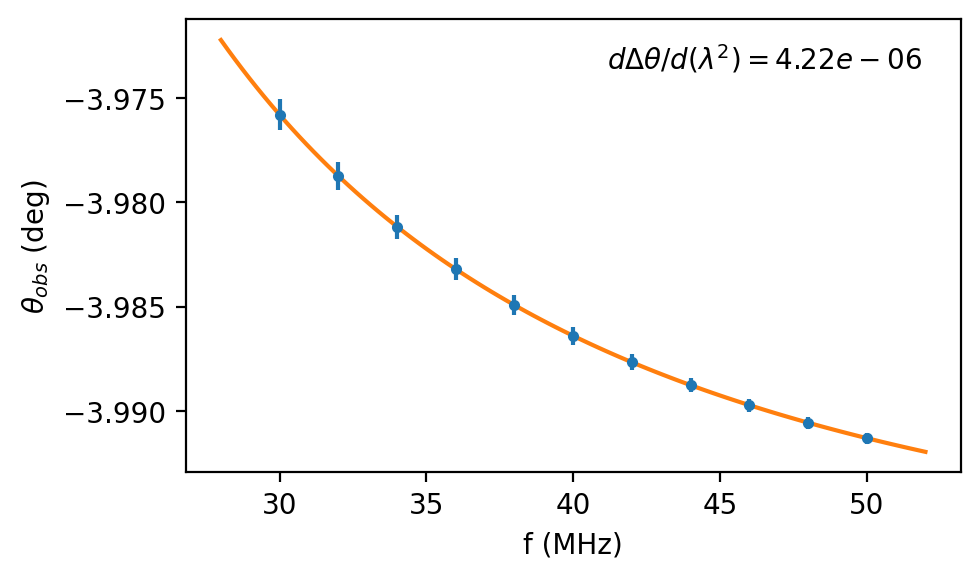

In [283]:

fit_res = np.polyfit( (3e8/(np.array(fMHz_batch)*1e6))**2,np.array(mean_theta),1)

fig = plt.figure(figsize=[5,3],dpi=200)
plt.errorbar(fMHz_batch,mean_theta,yerr=np.array(std_theta)*5,fmt='.')

fMHz_plt = np.linspace(28,52,100)
plt.plot(fMHz_plt,(3e8/(fMHz_plt*1e6))**2 *fit_res[0]+ fit_res[1],'-')
plt.setp(plt.gca(),xlabel='f (MHz)',ylabel=r'$\theta_{obs}$ (deg)')

# text at top right corner
plt.text(0.95, 0.95, r'$d\Delta\theta/d(\lambda^2) = 4.22e-06$',
        verticalalignment='top', horizontalalignment='right',
        transform=plt.gca().transAxes)

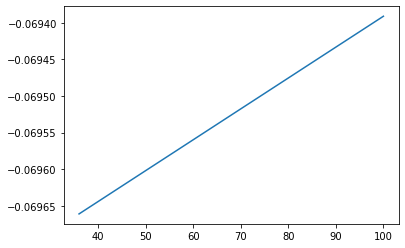

In [276]:
plt.plot((3e8/(np.array(fMHz_batch)*1e6))**2,np.array(mean_theta)*np.pi/180)

In [275]:
np.polyfit( (3e8/(np.array(fMHz_batch)*1e6))**2,np.array(mean_theta)*np.pi/180,1)

array([ 4.22243923e-06, -6.98131203e-02])

In [83]:
(r_vec_stat_avail,k_vec_stat_avail,t_reach_stat_avail,tau_stat_avail,
                r_vec_0, k_vec_0) =  raystat.reduct_lv1(
                    photon_N,r_vec_collect_local,k_vec_collect_local,
                    t_collect,tau_collect_local,omega0,num_t_bins=60)
                    
#(r_vec_stat_avail,k_vec_stat_avail,t_reach_stat_avail,dk_refr_avail,
#                r_vec_0, k_vec_0) =  raystat.reduct_lv1(
#                    photon_N,r_vec_collect_local,k_vec_collect_local,
#                    t_collect,dk_refr_collect,omega0,num_t_bins=60)
                    
#(r_vec_stat_avail,k_vec_stat_avail,t_reach_stat_avail,dk_scat_avail,
#                r_vec_0, k_vec_0) =  raystat.reduct_lv1(
#                    photon_N,r_vec_collect_local,k_vec_collect_local,
#                    t_collect,dk_scat_collect,omega0,num_t_bins=60)

In [84]:
#hst=plt.hist((dk_scat_avail/dk_refr_avail),100)

In [85]:
ang_rot = -65

# Important !!! rotate the initial point
r_vec_rot,k_vec_rot = raystat.rotateCoordKX(r_vec_stat_avail,k_vec_stat_avail,-ang_rot*np.pi/180)
r_vec0_rot,k_vec0_rot = raystat.rotateCoordKX(r_vec_0,k_vec_0,-ang_rot*np.pi/180)

(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_free_stat,idx_for_stat
    )=raystat.ImgXYtEstimate(r_vec_rot,k_vec_rot,t_reach_stat_avail,
            tau_stat_avail,r_vec0_rot, k_vec0_rot,num_t_bins=60)

#dk_scat_avail[idx_for_stat]
#dk_refr_avail[idx_for_stat]

In [86]:
weights_stat.shape

(0,)

In [87]:


#(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_free_stat
#    )=raystat.ImgXYtEstimate(r_vec_stat_avail,k_vec_stat_avail,t_reach_stat_avail,
#            tau_stat_avail,r_vec_0, k_vec_0,num_t_bins=60)

from sunRay.showPlot import XYDistributionImageHist

XYDistributionImageHist(x_im_stat,y_im_stat,bins_data=np.linspace(-2.5,2.5,100)
            ,weights_data=weights_stat)

#plt.gcf().savefig('run1.pdf')

/home/peijin/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/peijin/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/peijin/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../1acea6f6c115d0ec7a634ed0529287b9.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.5 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 1acea6f6c115d0ec7a634ed0529287b9.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../1acea6f6c115d0ec7a634ed0529287b9.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.5 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on 1acea6f6c115d0ec7a634ed0529287b9.log.




<Figure size 288x288 with 3 Axes>

In [60]:
from sunRay.showPlot import XYVariationPlot

#XYVariationPlot(x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_step = 0.03)

raystat.centroidXYFWHM(x_im_stat,y_im_stat,weights_stat)

(-1.2307616798598857,
 0.001726318290495363,
 0.16947201281722324,
 0.2750911214710589,
 0.00265800068574453,
 0.004314531805914777,
 0.008852399356748602,
 0.014369431425730758)

In [56]:
(-1.268899 -1.226425)/2

-1.247662

In [76]:
x_im_stat.dtype

dtype('float64')

time: 161 ms


In [ ]:
torch.sort(tau)[0][0]

In [49]:

t_collect

tensor([4.4008e-04, 1.5403e-02, 2.9925e-02, 4.4888e-02, 5.9410e-02, 7.4373e-02,
        8.8895e-02, 1.0386e-01, 1.1838e-01, 1.3334e-01, 1.4831e-01, 1.6283e-01,
        1.7779e-01, 1.9231e-01, 2.0728e-01, 2.2180e-01, 2.3706e-01, 2.5231e-01,
        2.6864e-01, 2.8506e-01, 3.0366e-01, 3.2405e-01, 3.4565e-01, 3.6915e-01,
        3.9385e-01, 4.2297e-01, 4.5586e-01, 4.9590e-01, 5.4317e-01, 6.0406e-01,
        6.8098e-01, 7.8152e-01, 9.4278e-01, 1.2286e+00, 2.3544e+00, 3.9940e+00,
        5.6832e+00, 7.3228e+00, 9.0120e+00, 1.0652e+01, 1.2341e+01, 1.4030e+01,
        1.5670e+01, 1.7359e+01, 1.8998e+01, 2.0688e+01, 2.2327e+01, 2.4016e+01,
        2.5656e+01, 2.7345e+01, 2.9034e+01, 3.0674e+01, 3.2363e+01, 3.4003e+01,
        3.5692e+01, 3.7331e+01, 3.9020e+01, 4.0660e+01, 4.2349e+01, 4.3989e+01,
        4.5678e+01, 4.7367e+01, 4.9007e+01, 5.0696e+01, 5.2335e+01, 5.4025e+01,
        5.5664e+01, 5.7353e+01, 5.8993e+01, 6.0682e+01, 6.2371e+01, 6.4011e+01,
        6.5700e+01, 6.7340e+01, 6.9029e+

time: 158 ms


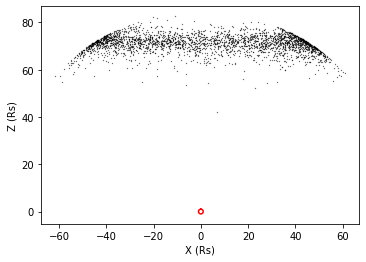

time: 847 ms


In [66]:
# plot the position in process
idx = -1
idx_select = np.sqrt(np.sum(r_vec_collect_local**2,axis=1)[-1,:])<84.7
plt.plot(r_vec_collect_local[idx,0,idx_select],r_vec_collect_local[idx,2,idx_select],'k.',markersize=0.5)
plt.plot(np.sin(np.linspace(0,np.pi*2,300)),
        np.cos(np.linspace(0,np.pi*2,300)),'r')
plt.xlabel('X (Rs)')
plt.ylabel('Z (Rs)')
plt.gca().set_aspect('equal')

In [53]:
idx_select=[np.sqrt(np.sum(r_vec_collect_local**2,axis=1)[-1,:])>84]

array([ True,  True,  True, ...,  True,  True,  True])

time: 167 ms


In [ ]:
# plot ray

idx_select = np.nonzero(((r_vec_collect_local[-1,0,:])**2+r_vec_collect_local[-1,1,:]**2)>0.5)
for num in (idx_select):
        plt.plot(r_vec_collect_local[:,2,num],r_vec_collect_local[:,0,num])
        plt.gca().set_aspect('equal')

In [ ]:
# inspect ray 
idx_select = np.nonzero(((r_vec_collect_local[-1,1,:])**2+r_vec_collect_local[-1,2,:]**2)<0.2)

idx_select = np.nonzero(((torch.sum(r_vec_collect[0,:,:].reshape(-1,3)*k_vec_collect[0,:,:].reshape(-1,3),1))).cpu()>1000)
#hst = plt.hist(k_vec_collect_local[0,:,idx_select])

#hst=plt.hist(torch.sum(r_vec_collect[99,:,idx_select].reshape(-1,3)*k_vec_collect[99,:,idx_select].reshape(-1,3),1).cpu().data.numpy(),100)
print(len(idx_select))
plt.plot(r_vec_collect_local[-1,0,idx_select],r_vec_collect_local[-1,2,idx_select],'k.',markersize=0.5)
plt.plot(np.sin(np.linspace(0,np.pi*2,300)),
        np.cos(np.linspace(0,np.pi*2,300)),'r')
plt.xlabel('X (Rs)')
plt.ylabel('Z (Rs)')
plt.gca().set_aspect('equal')

In [ ]:
idx_select = np.nonzero(((r_vec_collect_local[-1,1,:])**2+r_vec_collect_local[-1,2,:]**2)>1)

#hst=plt.hist(((torch.sum(r_vec_collect[0,:,:].reshape(-1,3)*k_vec_collect[0,:,:].reshape(-1,3),1))).numpy(),100)

hst=plt.hist(((torch.sum(r_vec[:,idx_select]*k_vec[:,idx_select],axis=0)).view(-1)).cpu().numpy(),500)

In [ ]:
hst=plt.hist(((torch.sum(r_vec.cpu()[:,:]*k_vec.cpu()[:,:],axis=0))).numpy(),100)

In [ ]:
plt.plot(k_vec_collect[0,0,:],k_vec_collect[0,1,:],'k.')

In [ ]:
freq = pfreq.omega_pe_r(ne_r,torch.Tensor(np.linspace(2,50,400)).to(dev_u))/(2*PI)

In [ ]:
cProfile.run('exec(open("sunRay_v0.py").read())')

In [ ]:
kc_cur/kc_norm

In [ ]:
t_collect.shape

In [ ]:
plt.plot(k_vec_collect[:,0,0],k_vec_collect[:,0,1],'k.')

In [ ]:
for num in range(100):
    plt.plot(r_vec_collect[:,2,num],r_vec_collect[:,1,num])
    plt.axis('equal')

In [ ]:
amp = lambda x : torch.sqrt(torch.sum(x.pow(2),axis=0))

plt.plot(amp(r_vec),amp(domega_pe_dxyz),'k.')

In [ ]:
domega_pe_dr.repeat(3,1).shape

In [ ]:
pfreq.omega_pe_r(ne_r,rr_cur)[0]

In [ ]:
rr_test = torch.linspace(20,100,100)
plt.plot(rr_test,pfreq.omega_pe_r(ne_r,rr_test))


In [ ]:
rr_cur

In [ ]:
start_r

In [ ]:
r_vec_collect.shape[2]

In [ ]:
# a test for the transformation

In [ ]:
# rotate the k vec into the r-z coordinate
kcx = - kx_cur*torch.sin(fi) + ky_cur*torch.cos(fi) 
kcy = (- kx_cur*costheta*torch.cos(fi) 
    - ky_cur*costheta*torch.sin(fi) + kz_cur*sintheta) 
kcz = (  kx_cur*sintheta*torch.cos(fi) 
    + ky_cur*sintheta*torch.sin(fi) + kz_cur*costheta)


kx_cur1 = (-kcx*torch.sin(fi) 
    -kcy*costheta*torch.cos(fi) +kcz*sintheta*torch.cos(fi) )
ky_cur1 = ( kcx*torch.cos(fi) 
    -kcy*costheta*torch.sin(fi) +kcz*sintheta*torch.sin(fi) )
kz_cur1 =  kcy*sintheta+kcz*costheta


In [ ]:
torch.max(kz_cur1/kz_cur-1)

In [ ]:
torch.atan(torch.Tensor([2]))

In [ ]:
plt.hist(torch.sum(r_vec*k_vec,0).cpu())

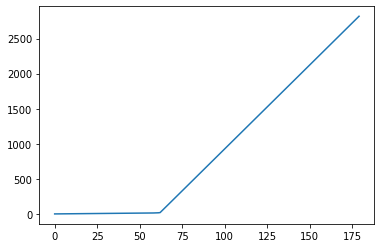

time: 479 ms


In [8]:
plt.plot(np.array(np.array(t_collect)))

In [58]:
np.savez('sunray_small_float32_20deg_0.3_0.1.npz', steps_N  = steps_N, collect_N = collect_N,
    photon_N = photon_N, start_r = start_r, start_theta = start_theta,
    start_phi  = start_phi, f_ratio  = f_ratio, epsilon = epsilon ,
    anis = anis, asym = asym,
    omega0=omega0.cpu(),
    freq0=freq0.cpu(),
    t_collect=t_collect.cpu(), tau=tau.cpu(),
    r_vec_collect_local=r_vec_collect_local,
    k_vec_collect_local=k_vec_collect_local,
    tau_collect_local = tau_collect_local)

time: 324 ms


torch.return_types.sort(
values=tensor([390.1856, 390.6868, 390.8470,  ..., 393.6197, 393.6219, 393.6273]),
indices=tensor([ 915, 3975, 3049,  ..., 1773,  250, 4476]))

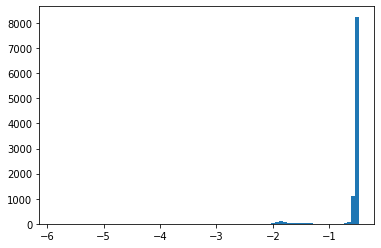

time: 648 ms


In [7]:
hst=plt.hist((-tau.cpu()),80)
torch.sort(rr_cur)

0.19202512404830618


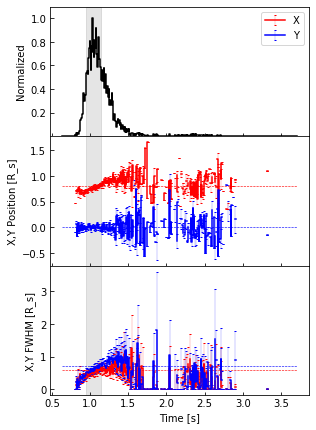

time: 2.17 s


In [8]:
from sunRay.showPlot import XYVariationPlot
gcf=XYVariationPlot(x_im_stat,y_im_stat,t_reach_stat,weights_stat,t_step = 0.008)

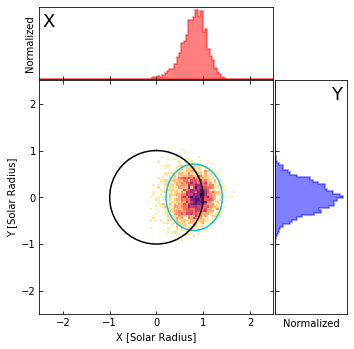

time: 1.14 s


In [9]:



from sunRay.showPlot import XYDistributionImageHist

XYDistributionImageHist(x_im_stat,y_im_stat,bins_data=np.linspace(-2.5,2.5,100)
            ,weights_data=weights_stat)

In [20]:
r_vec

tensor([[-17.6898, -10.5367,  14.8671,  ...,  39.0303,  31.4664,      nan],
        [  2.4447,  -9.2189, -19.9277,  ...,   6.3433, -31.0992,      nan],
        [ 46.2711,  47.4065,  42.8635,  ...,  30.7063,  22.0096,      nan]],
       device='cuda:0')

time: 29 ms


In [64]:
print(np.sqrt(np.sum((r_vec_collect_local[0,:,140])**2)))
        

1.7500131
time: 120 ms


In [7]:
import sunRay.tool as stool

print(stool.R_to_freq(1.75,1.1))
print(stool.R_to_freq(2.10428659,2))

stool.freq_to_R(35045076,2)

tensor([35045076.])
tensor([35045072.])


/home/amax/anaconda3/envs/torch15/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([2.10428659])

In [13]:
print(stool.freq_to_R(60e6,2))
print(stool.freq_to_R(65e6,2))
print(stool.freq_to_R(70e6,2))
print(stool.freq_to_R(75e6,2))


[1.78028301]
[1.74022034]
[1.70490162]
[1.67350443]


In [8]:
torch.atan2(torch.Tensor([1]),torch.Tensor([0]))

tensor([1.5708])

In [12]:
def a(a):
    return 1,2,3

In [1]:
import sunRay.densityModel as dm

(0.0, 15.2)

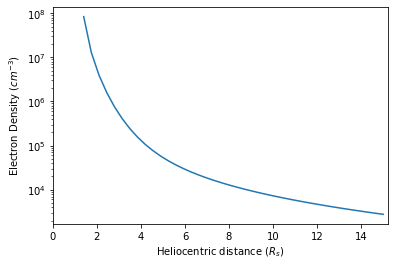

In [14]:
rrr=np.linspace(1.4,15,40)
#fig = plt.figure(figsize=[4,4],dpi=300)
ax = plt.gca()
ax.plot(rrr,dm.parkerfit(torch.Tensor(rrr)).cpu())
ax.set_xlabel(r'Heliocentric distance ($R_s$)')
ax.set_ylabel(r'Electron Density ($cm^{-3}$)')
ax.set_yscale('log')
ax.set_xlim([0,15.2])


(0.0, 15.2)

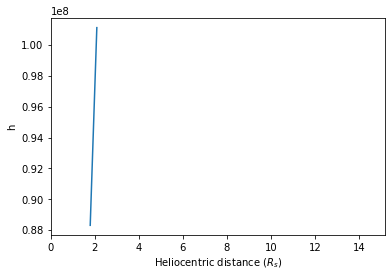

In [15]:
rrr=np.linspace(1.8,2.1
            ,40)
l_i = 1.0e5* rrr
l_0 = 0.23e0* 6.9e10*rrr**0.82
    
ax = plt.gca()
ax.plot(rrr,l_0**(2./3.) * l_i**(1./3.)/ (np.pi**(3./2.)))
ax.set_xlabel(r'Heliocentric distance ($R_s$)')
ax.set_ylabel(r'h')
#ax.set_yscale('log')
ax.set_xlim([0,15.2])


(0.0, 15.2)

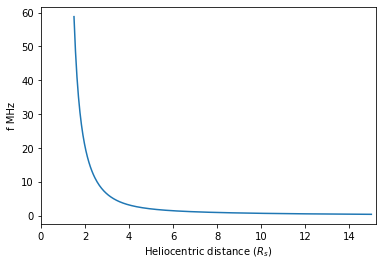

In [25]:
rrr=np.linspace(1.5,15,400)
#fig = plt.figure(figsize=[4,4],dpi=300)
ax = plt.gca()
ax.plot(rrr,8.93e3* (dm.parkerfit(torch.Tensor(rrr)).cpu())**(0.5) /1e6)
ax.set_xlabel(r'Heliocentric distance ($R_s$)')
ax.set_ylabel(r'f MHz')
#ax.set_yscale('log')
ax.set_xlim([0,15.2])

In [21]:
8.93e3* (dm.parkerfit(torch.Tensor([1.75])).cpu())**(0.5) /1e6

tensor([31.8592])

(0.0, 15.2)

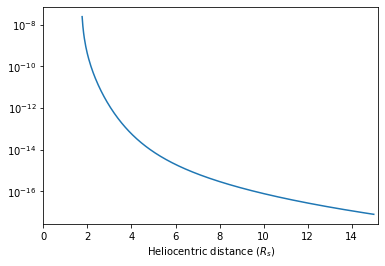

In [17]:
rrr=np.linspace(1.76,15,400)
#fig = plt.figure(figsize=[4,4],dpi=300)

wpe = 8.93e3* (dm.parkerfit(torch.Tensor(rrr)).numpy())**(0.5) * 2 * np.pi
w = 8.93e3* (dm.parkerfit(torch.Tensor([1.75])).numpy())**(0.5) * 2 * np.pi*1.1
eps = 0.3

l_i = 1.0e5* rrr
l_0 = 0.23e0* 6.9e10*rrr**0.82

h=l_0**(2./3.) * l_i**(1./3.)/ (np.pi**(3./2.))

ax = plt.gca()
ax.plot(rrr,np.pi/2*eps**2/h*wpe**4/(w**2-wpe**2)**2)
ax.set_xlabel(r'Heliocentric distance ($R_s$)')
ax.set_ylabel(r'')
ax.set_yscale('log')
ax.set_xlim([0,15.2])

In [40]:

rrr=2.1

l_i = 1.0e5* rrr
l_0 = 0.23e0* 6.9e10*rrr**0.82

h=l_0**(2./3.) * l_i**(1./3.)/ (np.pi**(3./2.))

In [39]:
h/1e5

861.3902630754685

In [41]:
h/1e5

1011.2987136501002

In [16]:
wpe = 8.93e3* (dm.parkerfit(torch.Tensor(rrr)).numpy())**(0.5) * 2 * np.pi


In [20]:
32 *1.1

35.2

In [21]:
import sunRay.tool as tool

In [22]:
tool.freq_to_R(150e6,1.1)

C:\Users\Pjer1\anaconda3\envs\lofarsun\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([2.])

In [30]:
tool.R_to_freq(1.3845,2.0)/1e6

tensor([172.9181])